In [1]:
import numpy as np
import pandas as pd

# Untuk visualisasi
import matplotlib.pyplot as plt
import seaborn as sns

# Untuk mengevaluasi performa model
from sklearn.metrics import f1_score, confusion_matrix

# Untuk melakukan ekstraksi data pada suatu kolom
import re 

# Membagi dataset menjadi train dan test set
from sklearn.model_selection import train_test_split

import time
import warnings
warnings.filterwarnings('ignore')

# Set rows ke 100 agar dapat melihat data lebih banyak
pd.set_option('display.max_rows', 100)

In [2]:
import pandas as pd; pd.set_option('display.max_columns', 100)
import numpy as np

import warnings
warnings.filterwarnings('ignore')

from tqdm.notebook import tqdm

import re

from functools import partial
from scipy.stats import mode

import matplotlib.pyplot as plt; plt.style.use('ggplot')
import seaborn as sns
import plotly.express as px

from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.preprocessing import MinMaxScaler, StandardScaler, LabelEncoder, FunctionTransformer, PowerTransformer, PolynomialFeatures
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.impute import KNNImputer
from sklearn.multiclass import OneVsRestClassifier
from sklearn.model_selection import KFold, StratifiedKFold, train_test_split, GridSearchCV, RepeatedStratifiedKFold, cross_val_score, cross_val_predict, cross_validate
from sklearn.metrics import roc_auc_score, roc_curve, RocCurveDisplay, cohen_kappa_score, log_loss, f1_score
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.feature_selection import RFE, RFECV
from sklearn.isotonic import IsotonicRegression
from sklearn.calibration import CalibrationDisplay, CalibratedClassifierCV
from sklearn.inspection import PartialDependenceDisplay, permutation_importance
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from collections import Counter
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier, HistGradientBoostingClassifier, GradientBoostingClassifier, ExtraTreesClassifier, VotingClassifier, StackingClassifier
from sklearn.svm import SVC
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier, Pool

import optuna
from optuna.samplers import TPESampler

In [3]:
X = pd.read_csv("train_features.csv")
y = pd.read_csv("train_labels.csv")
test = pd.read_csv("test_features.csv")
test = test.drop(['ID'], axis=1)
submission_format = pd.read_csv("submission_format.csv")

In [4]:
def summary(df):
    summ = pd.DataFrame(df.dtypes, columns=['data type'])
    summ['#missing'] = df.isnull().sum().values
    summ['Duplicate'] = df.duplicated().sum()
    summ['#unique'] = df.nunique().values
    desc = pd.DataFrame(df.describe(include='all').transpose())
    summ['min'] = desc['min'].values
    summ['max'] = desc['max'].values
    summ['avg'] = desc['mean'].values
    summ['std dev'] = desc['std'].values
    # summ['top value'] = desc['top'].values
    # summ['Freq'] = desc['freq'].values

    return summ

In [5]:
summary(X).style.background_gradient()

,data type,#missing,Duplicate,#unique,min,max,avg,std dev
tahun_kelahiran,int64,0,0,76,1899.000000,2000.000000,1967.823946,11.768131
pendidikan,object,189,0,6,nan,nan,nan,nan
status_pernikahan,object,212,0,6,nan,nan,nan,nan
pendapatan,float64,190,0,3622,5073000.000000,332884000.000000,114483170.089606,43460423.969516
jumlah_anak_balita,float64,190,0,3,0.000000,2.000000,0.293080,0.473063
jumlah_anak_remaja,float64,204,0,3,0.000000,2.000000,0.353723,0.493014
terakhir_belanja,float64,172,0,113,0.000000,128.000000,47.231550,27.068512
belanja_buah,float64,181,0,2535,0.000000,396508.000000,59804.239824,74024.976109
belanja_daging,float64,178,0,2951,0.000000,3489675.000000,438574.823853,512042.740059
belanja_ikan,float64,193,0,2627,0.000000,621600.000000,81428.997792,99976.226855


In [6]:
summary(test).style.background_gradient()

,data type,#missing,Duplicate,#unique,min,max,avg,std dev
tahun_kelahiran,int64,0,0,85,1892.000000,2009.000000,1967.789942,11.808572
pendidikan,object,204,0,6,nan,nan,nan,nan
status_pernikahan,object,182,0,6,nan,nan,nan,nan
pendapatan,float64,203,0,3610,2998899.000000,1305740000.000000,116324904.534716,51051222.459486
jumlah_anak_balita,float64,209,0,3,0.000000,2.000000,0.282904,0.465005
jumlah_anak_remaja,float64,210,0,3,0.000000,2.000000,0.355322,0.496865
terakhir_belanja,float64,201,0,116,0.000000,133.000000,47.181366,26.940287
belanja_buah,float64,186,0,2573,0.000000,408646.000000,61234.083425,76647.590617
belanja_daging,float64,195,0,2943,0.000000,3271191.000000,452848.379796,512320.643716
belanja_ikan,float64,196,0,2660,0.000000,574932.000000,85338.612093,103789.546199


In [7]:
train = pd.concat([X, y], axis=1)

In [8]:
train.sample(10)

,tahun_kelahiran,pendidikan,status_pernikahan,pendapatan,jumlah_anak_balita,jumlah_anak_remaja,terakhir_belanja,belanja_buah,belanja_daging,belanja_ikan,belanja_kue,pembelian_diskon,pembelian_web,pembelian_toko,keluhan,tanggal_menjadi_anggota,jumlah_promosi
137,1977,Doktor,Rencana Menikah,136519717.0,0.0,0.0,61.0,92790.0,796908.0,NaN,97699.0,0.0,4.0,6.0,0.0,NaN,2
2832,1951,Magister,Rencana Menikah,142649000.0,0.0,1.0,27.0,72828.0,NaN,119357.0,34391.0,0.0,1.0,8.0,0.0,2014-06-03,0
696,1958,Magister,Sendiri,NaN,1.0,1.0,51.0,0.0,26299.0,10115.0,2023.0,2.0,0.0,5.0,0.0,2014-06-02,1
1260,1972,Sarjana,Sendiri,49160873.0,1.0,0.0,16.0,11939.0,28401.0,10551.0,26219.0,1.0,3.0,3.0,0.0,NaN,3
1453,1989,SMP,Sendiri,39471000.0,1.0,0.0,35.0,26299.0,18207.0,32368.0,20230.0,0.0,4.0,4.0,0.0,2014-05-28,0
863,1953,Sarjana,Rencana Menikah,96720614.0,0.0,1.0,20.0,13515.0,333898.0,39230.0,70940.0,4.0,9.0,6.0,0.0,NaN,3
2971,1957,SMA,Menikah,166722000.0,0.0,0.0,35.0,103173.0,1699320.0,410669.0,279174.0,0.0,8.0,12.0,0.0,NaN,4
3363,1972,Magister,Rencana Menikah,91610000.0,1.0,1.0,31.0,10115.0,173978.0,2023.0,0.0,4.0,6.0,6.0,0.0,2014-02-12,0
3321,1956,SMA,Rencana Menikah,151953797.0,0.0,0.0,22.0,271320.0,463123.0,114227.0,287057.0,3.0,2.0,9.0,0.0,NaN,1
2135,1969,Sarjana,Sendiri,NaN,0.0,0.0,49.0,29932.0,538378.0,27622.0,39397.0,4.0,1.0,9.0,0.0,NaN,5


Text(0, 0.5, 'Percentage')

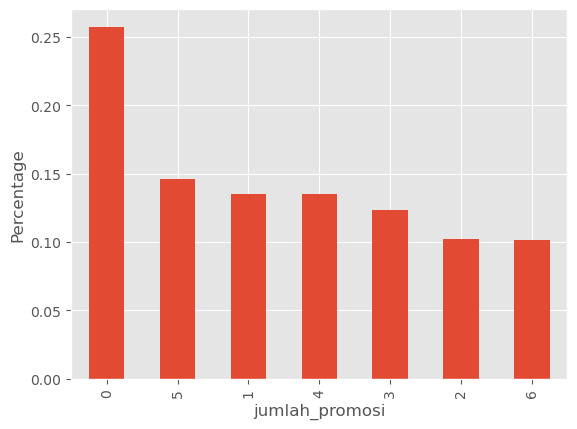

In [9]:
train['jumlah_promosi'].value_counts(normalize = True).plot(kind = 'bar')
plt.ylabel('Percentage')

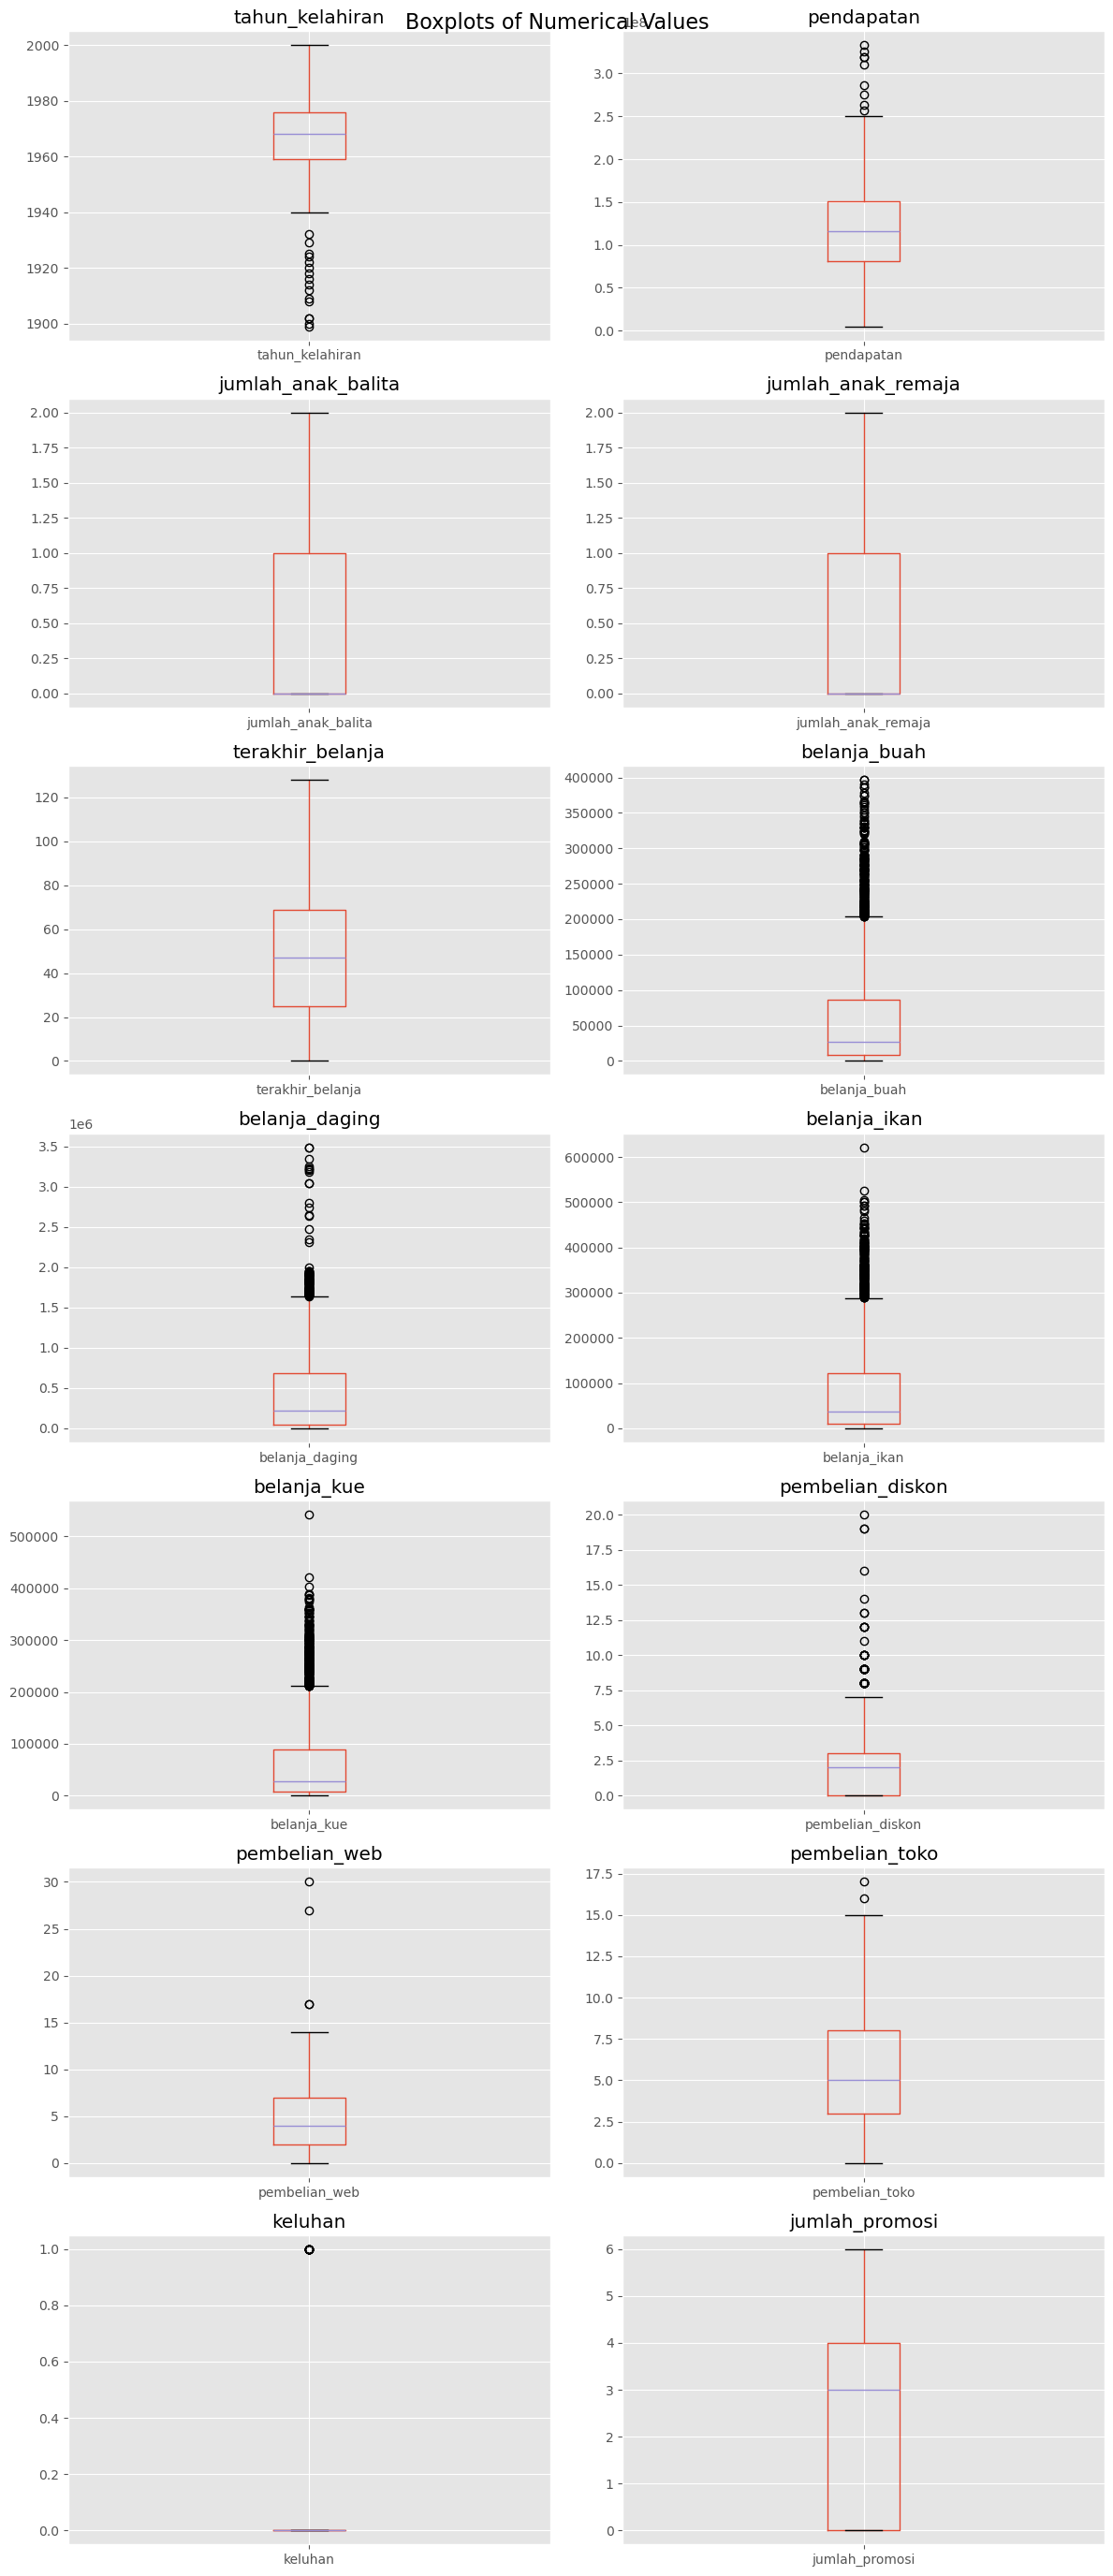

In [10]:
numerical_data = train.select_dtypes(include=[np.number])  # Select numerical columns

num_cols = numerical_data.shape[1]
num_rows = int(np.ceil(num_cols / 2))

fig, axes = plt.subplots(num_rows, 2, figsize=(12, num_rows * 4))
fig.suptitle('Boxplots of Numerical Values', fontsize=16)

for i, column in enumerate(numerical_data.columns):
    ax = axes[i // 2, i % 2] if num_rows > 1 else axes[i % 2]
    numerical_data.boxplot(column=column, ax=ax)
    ax.set_title(column)
    

plt.tight_layout()
plt.show()

In [11]:
train.value_counts('pendidikan')

pendidikan
Sarjana     1841
Magister     856
SMA          435
Doktor       403
SMP           91
5              2
Name: count, dtype: int64

In [12]:
train.value_counts('status_pernikahan')

status_pernikahan
Rencana Menikah    1271
Menikah            1114
Sendiri             965
Cerai               214
Cerai Mati           40
5                     1
Name: count, dtype: int64

In [13]:
table = contingency_table = pd.crosstab(train['pendidikan'], train['jumlah_promosi'])
table

jumlah_promosi,0,1,2,3,4,5,6
pendidikan,,,,,,,
5,2,0,0,0,0,0,0
Doktor,162,54,37,62,10,43,35
Magister,170,91,71,148,126,159,91
SMA,119,63,76,44,55,45,33
SMP,47,10,18,9,0,0,7
Sarjana,424,271,170,195,301,289,191


In [14]:
def preprocessing(df):
    df = df.drop(['tanggal_menjadi_anggota','keluhan'], axis=1)
    
    df['pendidikan'] = df['pendidikan'].map({'SMP': 1, 'SMA': 2, 'Sarjana': 3, 'Magister': 4, 'Doktor': 5})
    df['status_pernikahan'] = df['status_pernikahan'].map({'Sendiri': 1, 'Rencana Menikah': 2, 'Menikah': 3, 'Cerai': 4, 'Cerai Mati': 5})
    
    # Pemeblian diatas 15 diubah jadi 15
    # df.loc[df['pembelian_web'] > 15, 'pembelian_web'] = 15
    # df.loc[df['pembelian_toko'] > 15, 'pembelian_toko'] = 15
    
    # Fill Null Val dengan interpolate
    df['pendapatan'] = df['pendapatan'].interpolate(method ='pad', limit_direction ='forward')
    df['terakhir_belanja'] = df['terakhir_belanja'].interpolate(method ='pad', limit_direction ='forward')
    df['belanja_buah'] = df['belanja_buah'].interpolate(method ='pad', limit_direction ='forward')
    df['belanja_daging'] = df['belanja_daging'].interpolate(method ='pad', limit_direction ='forward')
    df['belanja_ikan'] = df['belanja_ikan'].interpolate(method ='pad', limit_direction ='forward')
    df['belanja_kue'] = df['belanja_kue'].interpolate(method ='pad', limit_direction ='forward')
    df['pembelian_diskon'] = df['pembelian_diskon'].interpolate(method ='pad', limit_direction ='forward')
    df['pembelian_toko'] = df['pembelian_toko'].interpolate(method ='pad', limit_direction ='forward')
    df['pembelian_web'] = df['pembelian_web'].interpolate(method ='pad', limit_direction ='forward')
    
    # Fill Null Val dengan median
    df = df.fillna(df.median())

    df = df.drop(['jumlah_anak_remaja','jumlah_anak_balita'], axis=1)
    
    # Change data type to int64
    numerical_data = df.select_dtypes(include=[np.number])  # Select numerical columns
    for i, column in enumerate(numerical_data.columns):
        df[column] = df[column].astype('int64')

    return df

In [15]:
# Preprocess train set
train = preprocessing(train)
summary(train).style.background_gradient()

,data type,#missing,Duplicate,#unique,min,max,avg,std dev
tahun_kelahiran,int64,0,0,76,1899.000000,2000.000000,1967.823946,11.768131
pendidikan,int64,0,0,5,1.000000,5.000000,3.273775,0.883832
status_pernikahan,int64,0,0,5,1.000000,5.000000,2.182604,0.911107
pendapatan,int64,0,0,3622,5073000.000000,332884000.000000,114502718.265392,43535581.079180
terakhir_belanja,int64,0,0,113,0.000000,128.000000,47.165051,27.038698
belanja_buah,int64,0,0,2535,0.000000,396508.000000,59942.936861,73936.467562
belanja_daging,int64,0,0,2951,0.000000,3489675.000000,437177.892062,510953.244736
belanja_ikan,int64,0,0,2627,0.000000,621600.000000,81472.008908,100224.593805
belanja_kue,int64,0,0,2475,0.000000,542164.000000,62981.860624,78954.662837
pembelian_diskon,int64,0,0,18,0.000000,20.000000,2.126801,2.096382


In [16]:
# Preprocess test set
test = preprocessing(test)
summary(test).style.background_gradient()

,data type,#missing,Duplicate,#unique,min,max,avg,std dev
tahun_kelahiran,int64,0,0,85,1892.000000,2009.000000,1967.789942,11.808572
pendidikan,int64,0,0,5,1.000000,5.000000,3.282609,0.851891
status_pernikahan,int64,0,0,5,1.000000,5.000000,2.194605,0.930997
pendapatan,int64,0,0,3610,2998899.000000,1305740000.000000,116065955.075694,50620219.819494
terakhir_belanja,int64,0,0,116,0.000000,133.000000,47.076742,26.937135
belanja_buah,int64,0,0,2573,0.000000,408646.000000,61269.735726,76725.515769
belanja_daging,int64,0,0,2943,0.000000,3271191.000000,451738.129125,510561.021483
belanja_ikan,int64,0,0,2660,0.000000,574932.000000,85158.235464,103303.662294
belanja_kue,int64,0,0,2526,0.000000,532049.000000,63653.494762,78511.934217
pembelian_diskon,int64,0,0,17,0.000000,17.000000,2.105029,2.122949


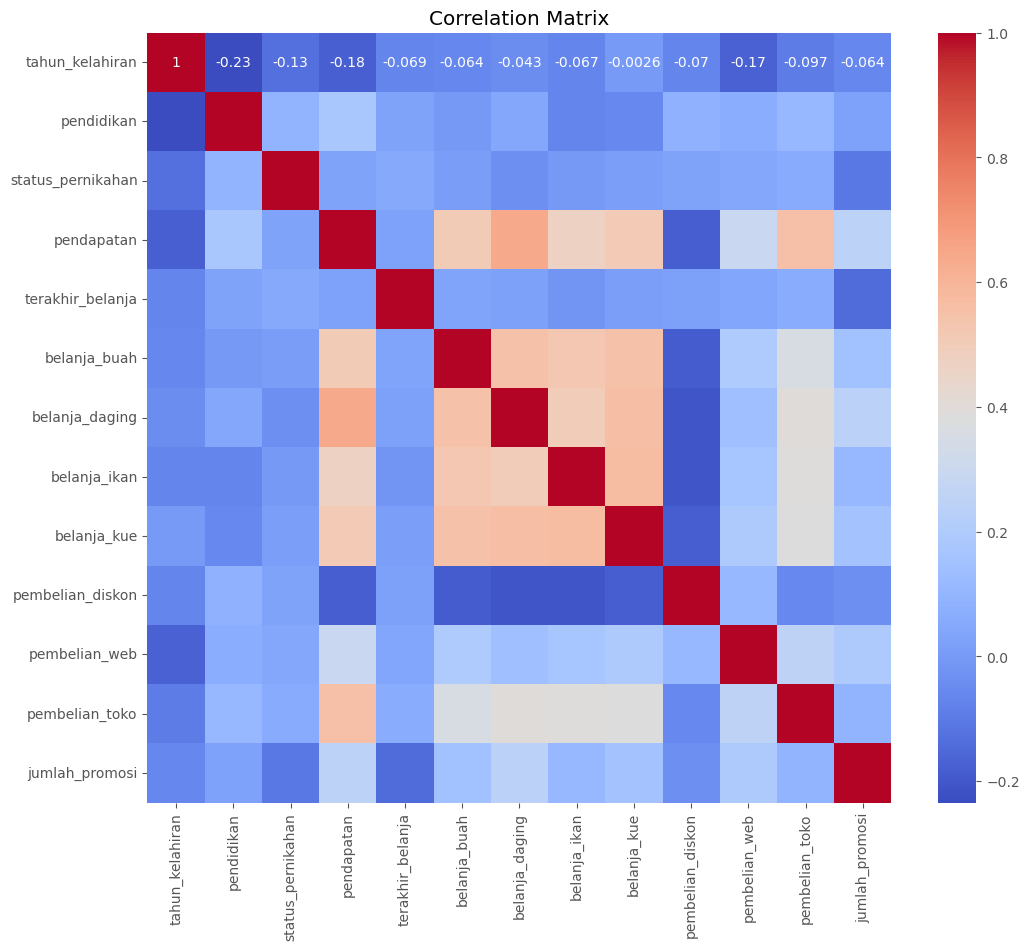

In [17]:
# Menghitung matriks korelasi
corr_matrix = train.corr()

# Membuat plot heatmap 
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')

plt.title('Correlation Matrix')
plt.show()

In [18]:
X = train.drop(columns = ['jumlah_promosi'], axis = 1)
y = train['jumlah_promosi']

In [19]:
skf = RepeatedStratifiedKFold(n_splits = 10, n_repeats = 1, random_state = 42)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Hyperparameter Tuning Optuna

In [20]:
# %%time
# def objective(trial):
#     # Number of trees in random forest
#     n_estimators = trial.suggest_int(name="n_estimators", low=100, high=1000)

#     # Number of features to consider at every split
#     max_features = trial.suggest_int(name="max_features", low=1, high=10)

#     # Maximum number of levels in tree
#     max_depth = trial.suggest_int(name="max_depth", low=10, high=100)

#     # Minimum number of samples required to split a node
#     min_samples_split = trial.suggest_int(name="min_samples_split", low=2, high=32)

#     # Minimum number of samples required at each leaf node
#     min_samples_leaf = trial.suggest_int(name="min_samples_leaf", low=1, high=32)
    
#     model = RandomForestClassifier(n_estimators = n_estimators, criterion = 'log_loss', max_depth =  max_depth,
#                                     min_samples_split =  min_samples_split, min_samples_leaf =  min_samples_leaf,
#                                     max_features =  max_features, random_state =  1, n_jobs =  -1)
    
#     score = cross_val_score(model, X_train, y_train, scoring = 'f1_macro', cv = skf, n_jobs = -1)
    
#     return score.mean() 

# optuna.logging.set_verbosity(optuna.logging.WARNING)

# sampler = TPESampler(seed=42)
# study = optuna.create_study(study_name="random_forest", direction="maximize", sampler=sampler)
# study.optimize(objective, n_trials=100)

# print("Number of finished trials: ", len(study.trials))
# print("Best trial:")
# trial = study.best_trial
# print("  Value: ", trial.value)
# print("  Params: ")
# for key, value in trial.params.items():
#     print(f"    {key}: {value}")

'''
Number of finished trials:  100
Best trial:
  Value:  0.7010996707754059
  Params: 
    n_estimators: 558
    max_features: 6
    max_depth: 59
    min_samples_split: 2
    min_samples_leaf: 1
CPU times: total: 1.91 s
Wall time: 10min 44s
'''

'\nNumber of finished trials:  100\nBest trial:\n  Value:  0.7010996707754059\n  Params: \n    n_estimators: 558\n    max_features: 6\n    max_depth: 59\n    min_samples_split: 2\n    min_samples_leaf: 1\nCPU times: total: 1.91 s\nWall time: 10min 44s\n'

In [22]:
%%time
def objective(trial):
    # Number of trees in random forest
    n_estimators = trial.suggest_int(name="n_estimators", low=100, high=1000)

    # Number of features to consider at every split
    max_features = trial.suggest_int(name="max_features", low=1, high=10)

    # Maximum number of levels in tree
    max_depth = trial.suggest_int(name="max_depth", low=10, high=100)

    # Minimum number of samples required to split a node
    min_samples_split = trial.suggest_int(name="min_samples_split", low=2, high=32)

    # Minimum number of samples required at each leaf node
    min_samples_leaf = trial.suggest_int(name="min_samples_leaf", low=1, high=32)
    
    model = ExtraTreesClassifier(n_estimators = n_estimators, criterion = 'log_loss', max_depth =  max_depth,
                                    min_samples_split =  min_samples_split, min_samples_leaf =  min_samples_leaf,
                                    max_features =  max_features, random_state =  1, n_jobs =  -1)
    
    score = cross_val_score(model, X, y, scoring = 'f1_macro', cv = skf, n_jobs = -1)
    
    return score.mean() 

# optuna.logging.set_verbosity(optuna.logging.WARNING)

sampler = TPESampler(seed=42)
study = optuna.create_study(study_name="random_forest", direction="maximize", sampler=sampler)
study.optimize(objective, n_trials=300)

print("Number of finished trials: ", len(study.trials))
print("Best trial:")
trial = study.best_trial
print("  Value: ", trial.value)
print("  Params: ")
for key, value in trial.params.items():
    print(f"    {key}: {value}")
    

'''
Number of finished trials:  200
Best trial:
  Value:  0.7308235668927672
  Params: 
    n_estimators: 407
    max_features: 10
    max_depth: 62
    min_samples_split: 2
    min_samples_leaf: 1
CPU times: total: 3.06 s
Wall time: 7min 43s
'''

[I 2024-04-20 01:32:59,365] A new study created in memory with name: random_forest
[I 2024-04-20 01:33:09,547] Trial 0 finished with value: 0.616534589269753 and parameters: {'n_estimators': 437, 'max_features': 10, 'max_depth': 76, 'min_samples_split': 20, 'min_samples_leaf': 5}. Best is trial 0 with value: 0.616534589269753.
[I 2024-04-20 01:33:10,780] Trial 1 finished with value: 0.05851175853524496 and parameters: {'n_estimators': 240, 'max_features': 1, 'max_depth': 88, 'min_samples_split': 20, 'min_samples_leaf': 23}. Best is trial 0 with value: 0.616534589269753.
[I 2024-04-20 01:33:12,317] Trial 2 finished with value: 0.6361528024245635 and parameters: {'n_estimators': 118, 'max_features': 10, 'max_depth': 85, 'min_samples_split': 8, 'min_samples_leaf': 6}. Best is trial 2 with value: 0.6361528024245635.
[I 2024-04-20 01:33:15,533] Trial 3 finished with value: 0.481710138009748 and parameters: {'n_estimators': 265, 'max_features': 4, 'max_depth': 57, 'min_samples_split': 15, 'm

Number of finished trials:  300
Best trial:
  Value:  0.7630096116494252
  Params: 
    n_estimators: 318
    max_features: 9
    max_depth: 66
    min_samples_split: 3
    min_samples_leaf: 1
CPU times: total: 47.4 s
Wall time: 52min 15s


'\nNumber of finished trials:  200\nBest trial:\n  Value:  0.7308235668927672\n  Params: \n    n_estimators: 407\n    max_features: 10\n    max_depth: 62\n    min_samples_split: 2\n    min_samples_leaf: 1\nCPU times: total: 3.06 s\nWall time: 7min 43s\n'

In [ ]:
optuna.visualization.plot_optimization_history(study)

In [ ]:
# %%time
# def objective(trial):
#     max_iter = trial.suggest_int(name="max_iter", low=100, high=1000)
#     learning_rate =  trial.suggest_float(name="learning_rate", low=0.01, high=0.2)
#     l2_regularization = trial.suggest_float(name='l2_regularization', low=0.0, high=10.0)
#     max_depth = trial.suggest_int(name="max_depth", low=1, high=50)
#     max_leaf_nodes = trial.suggest_int(name="max_leaf_nodes", low=2, high=32)
#     min_samples_leaf = trial.suggest_int(name="min_samples_leaf", low=1, high=32)
        
#     model = HistGradientBoostingClassifier(max_iter = max_iter, l2_regularization =  l2_regularization, loss = 'log_loss', max_depth =  max_depth, 
#                                         learning_rate =  learning_rate, max_leaf_nodes =  max_leaf_nodes, min_samples_leaf =  min_samples_leaf, 
#                                         max_bins =  255, early_stopping =  False, random_state =  1)
    
#     score = cross_val_score(model, X_train, y_train, scoring = 'f1_macro', cv = skf, n_jobs = -1)
    
#     return score.mean() 

# optuna.logging.set_verbosity(optuna.logging.WARNING)

# sampler = TPESampler(seed=42)
# study = optuna.create_study(study_name="random_forest", direction="maximize", sampler=sampler)
# study.optimize(objective, n_trials=200)

# print("Number of finished trials: ", len(study.trials))
# print("Best trial:")
# trial = study.best_trial
# print("  Value: ", trial.value)
# print("  Params: ")
# for key, value in trial.params.items():
#     print(f"    {key}: {value}")

# optuna.visualization.plot_optimization_history(study)
'''
Number of finished trials:  100
Best trial:
  Value:  0.709499535120383
  Params: 
    max_iter: 755
    learning_rate: 0.08069194222134556
    l2_regularization: 0.004071819616198791
    max_depth: 38
    max_leaf_nodes: 30
    min_samples_leaf: 4
CPU times: total: 2.38 s
Wall time: 20min 16s
'''

'\nNumber of finished trials:  100\nBest trial:\n  Value:  0.709499535120383\n  Params: \n    max_iter: 755\n    learning_rate: 0.08069194222134556\n    l2_regularization: 0.004071819616198791\n    max_depth: 38\n    max_leaf_nodes: 30\n    min_samples_leaf: 4\nCPU times: total: 2.38 s\nWall time: 20min 16s\n'

In [ ]:
# %%time
# def objective(trial):
#     n_estimators = trial.suggest_int(name="n_estimators", low=100, high=1000)
#     learning_rate =  trial.suggest_float(name="learning_rate", low=0.01, high=0.3)
#     max_depth = trial.suggest_int(name="max_depth", low=1, high=50)
#     subsample = trial.suggest_float(name='subsample', low=0.05, high=1.0)
#     min_child_weight = trial.suggest_int(name="min_child_weight", low=1, high=32)
#     gamma = trial.suggest_float(name="gamma", low=0.01, high=2.0)
#     colsample_bytree = trial.suggest_float(name="colsample_bytree", low=0.01, high=1.0)
#     reg_alpha = trial.suggest_loguniform('reg_alpha', 1e-8, 1.0)
#     reg_lambda = trial.suggest_loguniform('reg_lambda', 1e-8, 1.0)
        
#     model = XGBClassifier(n_estimators = n_estimators, subsample =  subsample, eval_metric = 'mlogloss', max_depth =  max_depth, 
#                                         learning_rate =  learning_rate, gamma =  gamma, min_child_weight =  min_child_weight, 
#                                         reg_alpha =  reg_alpha, reg_lambda =  reg_lambda, colsample_bytree =  colsample_bytree, random_state =  1)
    
#     score = cross_val_score(model, X_train, y_train, scoring = 'f1_macro', cv = skf, n_jobs = -1)
    
#     return score.mean() 

# optuna.logging.set_verbosity(optuna.logging.WARNING)

# sampler = TPESampler(seed=42)
# study = optuna.create_study(study_name="xgb", direction="maximize", sampler=sampler)
# study.optimize(objective, n_trials=200)

# print("Number of finished trials: ", len(study.trials))
# print("Best trial:")
# trial = study.best_trial
# print("  Value: ", trial.value)
# print("  Params: ")
# for key, value in trial.params.items():
#     print(f"    {key}: {value}")

# optuna.visualization.plot_optimization_history(study)
'''
Number of finished trials:  200
Best trial:
  Value:  0.7120976347731732
  Params: 
    n_estimators: 241
    learning_rate: 0.027071426847753828
    max_depth: 23
    subsample: 0.826267822451126
    min_child_weight: 1
    gamma: 0.07899077336556067
    colsample_bytree: 0.7273085926052265
    reg_alpha: 0.0011669044708923562
    reg_lambda: 1.7546953633442173e-05
CPU times: total: 3.11 s
Wall time: 12min 47s
'''

'\nNumber of finished trials:  200\nBest trial:\n  Value:  0.7120976347731732\n  Params: \n    n_estimators: 241\n    learning_rate: 0.027071426847753828\n    max_depth: 23\n    subsample: 0.826267822451126\n    min_child_weight: 1\n    gamma: 0.07899077336556067\n    colsample_bytree: 0.7273085926052265\n    reg_alpha: 0.0011669044708923562\n    reg_lambda: 1.7546953633442173e-05\nCPU times: total: 3.11 s\nWall time: 12min 47s\n'

In [ ]:
# %%time
# def objective(trial):
#     n_estimators = trial.suggest_int(name="n_estimators", low=100, high=1000)
#     learning_rate =  trial.suggest_float(name="learning_rate", low=0.01, high=0.3)
#     max_depth = trial.suggest_int(name="max_depth", low=1, high=30)
#     subsample = trial.suggest_float(name='subsample', low=0.05, high=1.0)
#     num_leaves = trial.suggest_int(name="num_leaves", low=2, high=50)
#     colsample_bytree = trial.suggest_float(name="colsample_bytree", low=0.01, high=1.0)
#     reg_alpha = trial.suggest_loguniform('reg_alpha', 1e-8, 1.0)
#     reg_lambda = trial.suggest_loguniform('reg_lambda', 1e-8, 1.0)
        
#     model = LGBMClassifier(n_estimators = n_estimators, subsample =  subsample, objective = 'multiclass', max_depth =  max_depth, 
#                                         learning_rate =  learning_rate, metric =  'multi_logloss', num_leaves =  num_leaves, 
#                                         reg_alpha =  reg_alpha, reg_lambda =  reg_lambda, colsample_bytree =  colsample_bytree, random_state =  1)
    
#     score = cross_val_score(model, X_train, y_train, scoring = 'f1_macro', cv = skf, n_jobs = -1)
    
#     return score.mean() 

# optuna.logging.set_verbosity(optuna.logging.WARNING)

# sampler = TPESampler(seed=42)
# study = optuna.create_study(study_name="xgb", direction="maximize", sampler=sampler)
# study.optimize(objective, n_trials=50)

# print("Number of finished trials: ", len(study.trials))
# print("Best trial:")
# trial = study.best_trial
# print("  Value: ", trial.value)
# print("  Params: ")
# for key, value in trial.params.items():
#     print(f"    {key}: {value}")

# optuna.visualization.plot_optimization_history(study)
'''
Number of finished trials:  50
Best trial:
  Value:  0.7170836609609632
  Params: 
    n_estimators: 580
    learning_rate: 0.07411418118537871
    max_depth: 28
    subsample: 0.10711522895628599
    num_leaves: 47
    colsample_bytree: 0.6307097794921823
    reg_alpha: 7.069568444843734e-08
    reg_lambda: 2.741985916881125e-06
CPU times: total: 6.95 s
Wall time: 59min 9s
'''

'\nNumber of finished trials:  50\nBest trial:\n  Value:  0.7170836609609632\n  Params: \n    n_estimators: 580\n    learning_rate: 0.07411418118537871\n    max_depth: 28\n    subsample: 0.10711522895628599\n    num_leaves: 47\n    colsample_bytree: 0.6307097794921823\n    reg_alpha: 7.069568444843734e-08\n    reg_lambda: 2.741985916881125e-06\nCPU times: total: 6.95 s\nWall time: 59min 9s\n'

In [ ]:
# %%time
# def objective(trial):
#     iterations = trial.suggest_int(name="iterations", low=100, high=1000)
#     learning_rate =  trial.suggest_float("learning_rate", 1e-3, 0.1, log=True)
#     depth = trial.suggest_int(name="depth", low=1, high=16)
#     # subsample = trial.suggest_float(name='subsample', low=0.05, high=1.0)
#     bagging_temperature = trial.suggest_float("bagging_temperature", 0, 10)
#     min_data_in_leaf = trial.suggest_int(name="min_data_in_leaf", low=1, high=50)
#     colsample_bylevel = trial.suggest_float(name="colsample_bylevel", low=0.05, high=1.0)
        
#     model = CatBoostClassifier(iterations = iterations, bagging_temperature =  bagging_temperature, depth =  depth, learning_rate =  learning_rate, 
#                                loss_function = 'MultiClass', min_data_in_leaf =  min_data_in_leaf, colsample_bylevel =  colsample_bylevel, 
#                                random_state =  1, allow_writing_files = False, silent=True)
    
#     score = cross_val_score(model, X_train, y_train, scoring = 'f1_macro', cv = skf, n_jobs = -1)
    
#     return score.mean() 

# # optuna.logging.set_verbosity(optuna.logging.WARNING)

# sampler = TPESampler(seed=42)
# study = optuna.create_study(study_name="catboost", direction="maximize", sampler=sampler)
# study.optimize(objective, n_trials=25)

# print("Number of finished trials: ", len(study.trials))
# print("Best trial:")
# trial = study.best_trial
# print("  Value: ", trial.value)
# print("  Params: ")
# for key, value in trial.params.items():
#     print(f"    {key}: {value}")

# optuna.visualization.plot_optimization_history(study)
'''

'''

'\n\n'

In [ ]:
# optuna.visualization.plot_optimization_history(study)

### Modelling Part 1

In [ ]:
%%time
# LogisticRegression
logit_cv = cross_val_score(make_pipeline(PowerTransformer(), LogisticRegression(multi_class = 'auto', max_iter = 1000)), 
                           X, y, scoring = 'f1_macro',cv = skf, n_jobs = -1)
print(f"The average 10-folds Macro F-Score score of the LR is {logit_cv.mean()} \n")

# RandomForestClassifier
RF_cv = cross_val_score(RandomForestClassifier(n_estimators = 558, max_features = 6, max_depth = 59, min_samples_split = 2,
                                                min_samples_leaf = 1, random_state = 1, criterion = 'log_loss', n_jobs = -1),
                        X, y, scoring = 'f1_macro', cv = skf, n_jobs = -1)
print(f"The average 10-folds Macro F-Score of the RF is {RF_cv.mean()} \n")

# ExtraTreesClassifier
ET_cv = cross_val_score(ExtraTreesClassifier(n_estimators = 407, max_features = 10, max_depth = 62, min_samples_split = 2,   
                                             min_samples_leaf = 1, criterion = 'log_loss', random_state = 1),
                        X, y, scoring = 'f1_macro', cv = skf, n_jobs = -1)
print(f"The average 10-folds Macro F-Score of the ET is {ET_cv.mean()} \n")

# HistGradientBoostingClassifier
HB_cv = cross_val_score(HistGradientBoostingClassifier(max_iter = 755, learning_rate = 0.08069194222134556, l2_regularization = 0.004071819616198791,
                                                       max_depth = 38, max_leaf_nodes = 30, min_samples_leaf = 4, loss = 'log_loss', max_bins =  255, 
                                                       early_stopping =  False, random_state =  1),
                        X, y, scoring = 'f1_macro', cv = skf, n_jobs = -1)
print(f"The average 10-fold Macro F-Score of the HG is {HB_cv.mean()} \n")

# XGBClassifier
XGB_cv = cross_val_score(XGBClassifier(n_estimators = 241, learning_rate = 0.027071426847753828, max_depth = 23, subsample = 0.826267822451126,
                                       min_child_weight = 1, gamma = 0.07899077336556067, colsample_bytree = 0.7273085926052265,
                                       reg_alpha = 0.0011669044708923562, reg_lambda = 1.7546953633442173e-05, random_state =  1),
                        X, y, scoring = 'f1_macro', cv = skf, n_jobs = -1)
print(f"The average 10-fold Macro F-Score of the XGB is {XGB_cv.mean()} \n")

# LGBMClassifier
LGBM_cv = cross_val_score(LGBMClassifier(n_estimators = 580, learning_rate = 0.07411418118537871, max_depth = 28, subsample = 0.10711522895628599,
                                         num_leaves = 47, colsample_bytree = 0.6307097794921823, reg_alpha = 7.069568444843734e-08,
                                         reg_lambda = 2.741985916881125e-06, random_state =  1), 
                        X, y, scoring = 'f1_macro', cv = skf, n_jobs = -1)
print(f"The average 10-fold Macro F-Score of the LGBM is {LGBM_cv.mean()} \n")

The average 10-folds Macro F-Score score of the LR is 0.23018312666162305 

The average 10-folds Macro F-Score of the RF is 0.7363619205594388 

The average 10-folds Macro F-Score of the ET is 0.7589181337871261 

The average 10-fold Macro F-Score of the HG is 0.7432196406805562 

The average 10-fold Macro F-Score of the XGB is 0.7454227740408982 

The average 10-fold Macro F-Score of the LGBM is 0.7422720738766213 

CPU times: total: 328 ms
Wall time: 3min 32s


In [ ]:
# %%time
# Cat_cv = cross_val_score(CatBoostClassifier(loss_function = 'MultiClass',
#                                             iterations = 2000,
#                                             learning_rate = 0.01,
#                                             depth = 8, 
#                                             verbose = False,
#                                             task_type = 'CPU'), 
#                           X,
#                           y,
#                           scoring = 'f1_macro',
#                           cv = skf, 
#                           n_jobs = -1)

# print(f"The average 10-folds Macro F-Score of the CatBoost model is {Cat_cv.mean()}") 


In [ ]:
# model_performance = pd.DataFrame()
# model_performance['Model'] = ['Logistic', 'RF', 'ET', 'Hist', 'LGBM', 'XGBoost', 'CatBoost']
# model_performance['10-folds Macro F-Score'] = [logit_cv.mean(), RF_cv.mean(), ET_cv.mean(), HB_cv.mean(), LGBM_cv.mean(), XGB_cv.mean(), Cat_cv.mean()]
# model_performance.style.hide()


### Model 1.1

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
model = RandomForestClassifier(n_estimators = 558, max_features = 6, max_depth = 59, min_samples_split = 2,
                                                min_samples_leaf = 1,random_state = 1, criterion = 'log_loss', n_jobs = -1)

model = ExtraTreesClassifier(n_estimators = 407, max_features = 10, max_depth = 62, min_samples_split = 2,   
                                             min_samples_leaf = 1, criterion = 'log_loss', random_state = 1)

# model = XGBClassifier(n_estimators = 241, learning_rate = 0.027071426847753828, max_depth = 23, subsample = 0.826267822451126,
#                                        min_child_weight = 1, gamma = 0.07899077336556067, colsample_bytree = 0.7273085926052265,
#                                        reg_alpha = 0.0011669044708923562, reg_lambda = 1.7546953633442173e-05, random_state =  1)

model.fit(X, y)
y_pred = model.predict(X_test)
print('F1: ', f1_score(y_test, y_pred, average='macro'))
submission = model.predict(test)

F1:  1.0


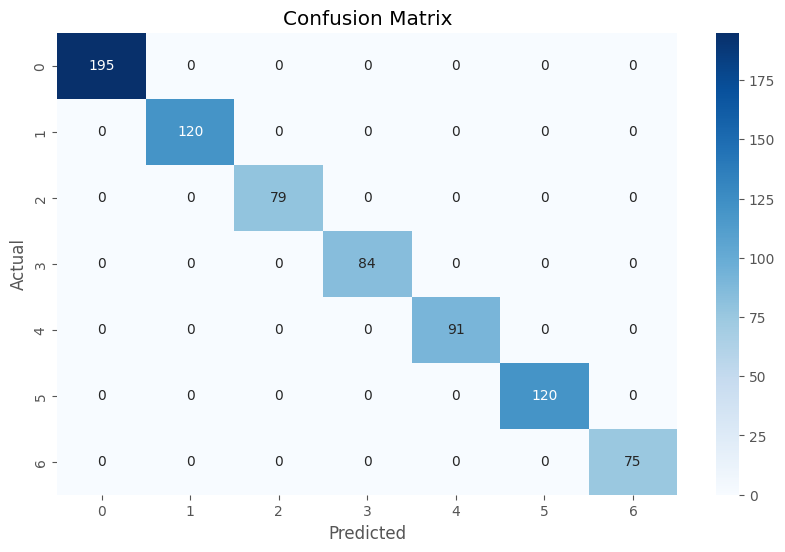

In [ ]:
plt.figure(figsize=(10, 6))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

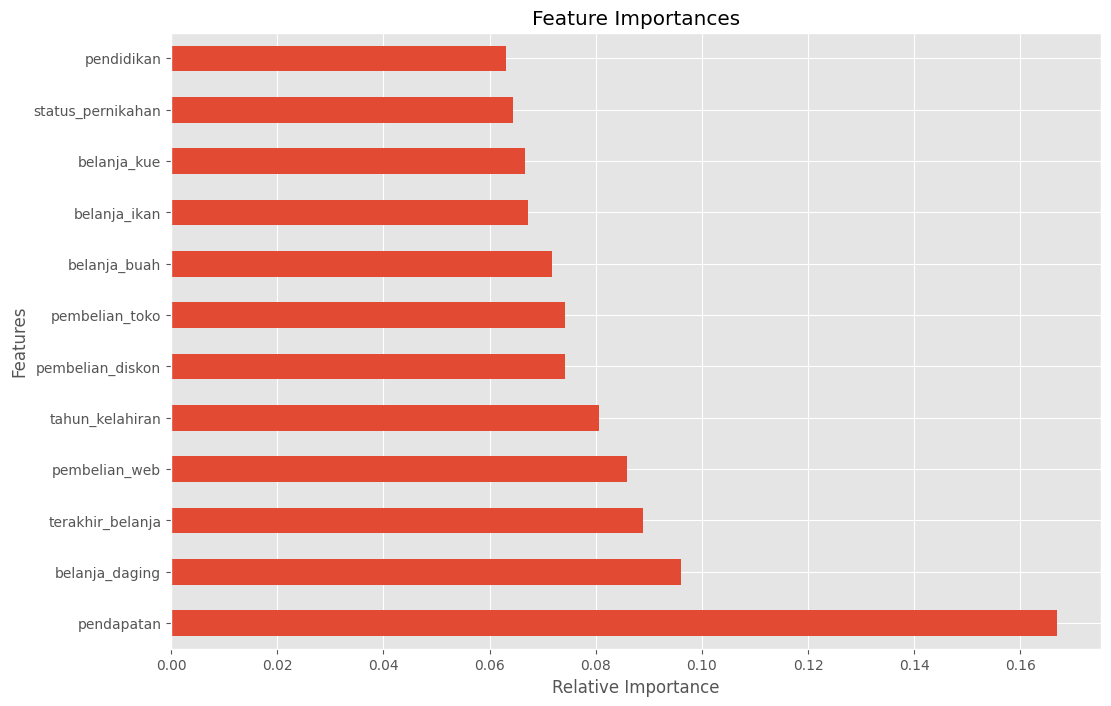

In [ ]:
plt.figure(figsize=(12, 8))
feat_importances = pd.Series(model.feature_importances_, index=X_train.columns)
feat_importances.nlargest(15).plot(kind='barh')
plt.title('Feature Importances')
plt.xlabel('Relative Importance')
plt.ylabel('Features')
plt.show()

In [ ]:
submission_format['jumlah_promosi'] = pd.DataFrame(submission)
submission_format.to_csv('submission_d.csv',index = False)

### Modeling Part 2

In [ ]:
# # Create a StandardScaler object
# scaler = StandardScaler()
# scaler.fit(X)
# X = scaler.transform(X)
# scaler.fit(test)
# test = scaler.transform(test)

In [ ]:
# from sklearn.model_selection import train_test_split

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


In [ ]:
# import tensorflow as tf
# from tensorflow.keras.layers import Dense
# from tensorflow.keras.models import Sequential

# # Assuming your data is loaded into NumPy arrays
# # print(X.shape)  # Shape (3817, 8)
# # print(y.shape)  # Shape (3817,) - Target labels (one-hot encoded or integers)

# # Define number of classes (modify based on your actual number of classes)
# num_classes = 7  # Replace with the actual number of classes in your data

# # One-hot encode target labels if they are not already encoded
# y = tf.keras.utils.to_categorical(y, num_classes)
# y_train = tf.keras.utils.to_categorical(y_train, num_classes)
# y_test = tf.keras.utils.to_categorical(y_test, num_classes)

# # Define the model
# model = Sequential([
#   Dense(128, activation='relu', input_shape=(8,)),  # Input layer with 8 features
#   Dense(64, activation='relu'),
#   Dense(7, activation='softmax')  # Output layer with num_classes units
# ])

# # Compile the model
# model.compile(loss='categorical_crossentropy',
#               optimizer='adam',
#               metrics=['accuracy', tf.keras.metrics.F1Score(average='macro')])

# # Train the model (adjust epochs and batch size as needed)
# history = model.fit(X_train, y_train, epochs=500, batch_size=32)

# # Evaluate the model (on separate test data for a more reliable assessment)
# loss, accuracy, f1_macro = model.evaluate(X_test, y_test)
# print('Test Loss:', loss)
# print('Test Accuracy:', accuracy)
# print('Test F1 Macro:', f1_macro)



In [ ]:
# submission = model.predict(test)
# submission_df =  pd.DataFrame(submission)
# submission_df

In [ ]:
# def get_max_col_name(row):
#   """
#   This function takes a pandas Series (row) and returns the name of the column
#   containing the maximum value.
#   """
#   # Find the index of the maximum value
#   max_index = row.idxmax()
#   return max_index

# # Apply the function to each row and create a new column 'max_col'
# submission_df['max_col'] = submission_df.apply(get_max_col_name, axis=1)

# submission_format['jumlah_promosi'] = submission_df['max_col']
# submission_format.to_csv('submission_d.csv',index = False)